In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
import math
from tqdm import tqdm

In [2]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [3]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel, GraphDiffusionFastGRFKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [4]:
def generate_random_graph_by_degree(num_nodes, average_degree):
    probability = average_degree / (num_nodes - 1)  # Calculate edge probability from average degree
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)
    return nx.to_numpy_array(G)

def gp_inference(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None)
    # model.likelihood.variance.prior = tfp.distributions.LogNormal(loc=np.log(0.07), scale=0.5)
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev
def evaluate_ml_diffusion(adjacency_matrix, X, Y, beta_values, noise_variance):
    ml_values = []
    for beta in beta_values:
        kernel = GraphDiffusionKernel(adjacency_matrix, beta=beta)
        model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
        model.likelihood.variance.assign(noise_variance)
        ml_values.append(np.exp(model.log_marginal_likelihood().numpy()))
    return ml_values

In [5]:
# Generate a random graph
num_nodes = 300
average_degree = 5
adjacency_matrix = generate_random_graph_by_degree(num_nodes, average_degree)

In [6]:
# Genrate Noisy Samples from the Graph By Sampling from a GP
beta_sample = 0.3
noise_std = 0.1

K_true = diffusion_kernel(adjacency_matrix, beta_sample)
Y_noisy = generate_noisy_samples(K_true, noise_std=noise_std)
X = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))
X_new = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))
Y = tf.reshape(tf.convert_to_tensor(Y_noisy, dtype=tf.float64), (-1, 1))

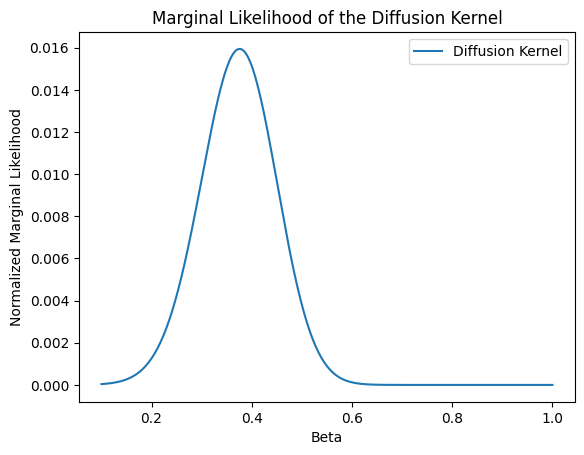

In [7]:
# Plot the marginal likelihood distribution to verify the correctness of the optimization

beta_values = np.linspace(0.1, 1, 300)

ml_values_diff = evaluate_ml_diffusion(adjacency_matrix, X, Y, beta_values, noise_std**2)
ml_values_diff_normalized = ml_values_diff / np.sum(ml_values_diff)

plt.plot(beta_values, ml_values_diff_normalized, label="Diffusion Kernel")
plt.xlabel("Beta")
plt.ylabel("Normalized Marginal Likelihood")
plt.title("Marginal Likelihood of the Diffusion Kernel")
plt.legend()
plt.show()

In [8]:
# Use the Exact Kernel to find the ML estimate of the hyperparameters

exact_kernel = GraphDiffusionKernel(adjacency_matrix, beta=0.5) # The initial beta value for optimizaiton
model, mean, stddev = gp_inference(X, Y, X_new, exact_kernel)
learned_beta_exact = model.kernel.beta.numpy()
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.362745    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.18937e-06 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════╛


In [9]:
# Define the range of walks_per_node values
walks_per_node_values = [1,2,4,8,16,32,64,128,256]
repeat = 10
learned_betas = {walks_per_node: [] for walks_per_node in walks_per_node_values}

# Perform GRF inference for each walks_per_node value and store the learned_beta values
for walks_per_node in tqdm(walks_per_node_values, desc="Processing walks_per_node values"):
    for i in range(repeat):
        grf_kernel = GraphDiffusionFastGRFKernel(
            adjacency_matrix,
            walks_per_node=walks_per_node,
            p_halt=0.1,
            max_walk_length=100,
            beta=0.1,  # Placeholder, will be overwritten in the loop
            random_walk_seed=i
        )
        model, mean, stddev = gp_inference(X, Y, X_new, grf_kernel)
        learned_beta_grf = model.kernel.beta.numpy()
        learned_betas[walks_per_node].append(learned_beta_grf)


Processing walks_per_node values: 100%|██████████| 9/9 [05:21<00:00, 35.68s/it]


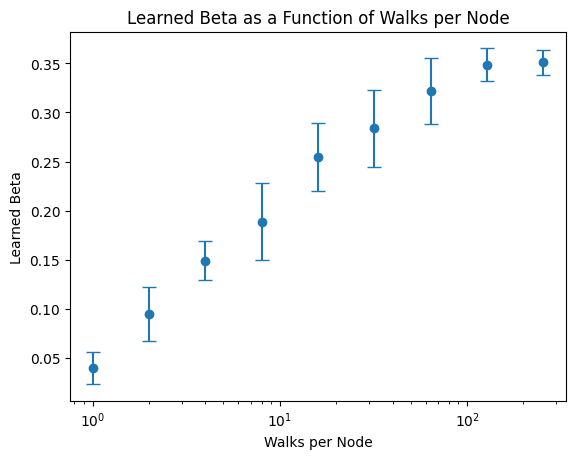

In [10]:
# Calculate the mean and standard deviation for plotting
learned_betas_mean = [np.mean(learned_betas[walks_per_node]) for walks_per_node in walks_per_node_values]
learned_betas_std = [np.std(learned_betas[walks_per_node]) for walks_per_node in walks_per_node_values]

# Plot learned_beta mean and std as a function of walks_per_node
plt.errorbar(walks_per_node_values, learned_betas_mean, yerr=learned_betas_std, fmt='o', capsize=5)
plt.xlabel("Walks per Node")
plt.ylabel("Learned Beta")
plt.xscale("log")
plt.title("Learned Beta as a Function of Walks per Node")
plt.show()

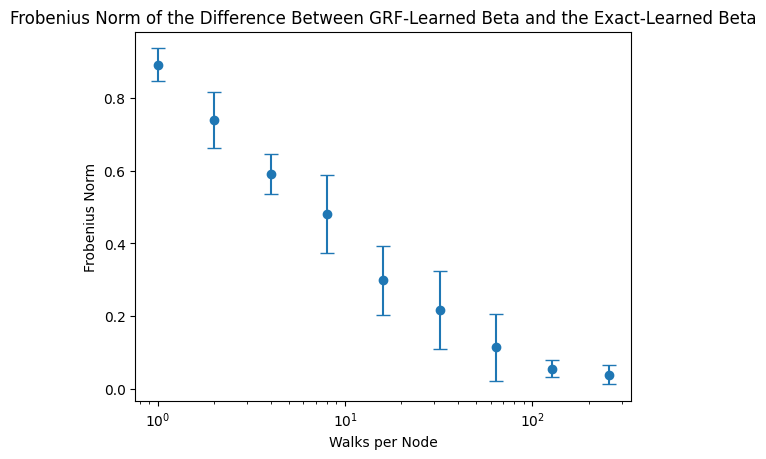

In [ ]:
# Note in this case beta is a scalar, but later for vector beta, we can use the following code to calculate the Frobenius norm

frobenius_norms = [[compute_fro(learned_beta_exact, learned_betas[walks_per_node][i]) for i in range(repeat)] for walks_per_node in walks_per_node_values]
frobenius_norms_mean = [np.mean(frobenius_norm) for frobenius_norm in frobenius_norms]
frobenius_norms_std = [np.std(frobenius_norm) for frobenius_norm in frobenius_norms]
plt.errorbar(walks_per_node_values, frobenius_norms_mean, yerr=frobenius_norms_std, fmt='o', capsize=5)
plt.xlabel("Walks per Node")
plt.ylabel("Frobenius Norm")
plt.xscale("log")
plt.title("Frobenius Norm of the Difference Between GRF-Learned Beta and the Diffusion-Learned Beta")
plt.show()
